In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os 
import shutil
import numpy as n
from datetime import date
import matplotlib.pyplot as plt
import time

In [4]:


os.chdir('/home/ali/packages/s2p-lbm/')
# from scipy import stats
import suite2p
from suite3d import plot_utils as plot

In [5]:
from importlib import reload
from pathlib import Path

In [6]:

from suite3d import ui

No Napari
No PyQtGraph


In [7]:
raw_data_path = '/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/raw'

save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/')

ops = suite2p.default_ops()
ops['look_one_level_down'] = True
ops['subfolders'] = []
ops['nplanes'] = 7
ops['fs'] = 4.12
ops['batch_size'] = 400
ops['threshold_scaling'] = 0.1
ops['tau'] = 1.3
ops['nonrigid'] = False
ops['ignore_flyback'] = []
ops['data_path'] = [raw_data_path]
ops['save_path0'] = str(save_path)
# print(ops)
ops['do_registration'] = 2

In [8]:
all_ops = []
all_stats = []
Fs = []
spks = []
iscell = []
for plane in n.arange(ops['nplanes']):
    planedir = (save_path / 'suite2p' / f'plane{plane}')
    statx = planedir / 'stat.npy'
    opx = planedir / 'ops.npy'
    Fsx = planedir / 'F.npy'
    spksx = planedir / 'spks.npy'
    iscellx = planedir / 'iscell.npy'
    
    all_stats.append(n.load(statx, allow_pickle=True))
    all_ops.append(n.load(opx, allow_pickle=True).item())
    Fs.append(n.load(Fsx))
    spks.append(n.load(spksx))
    iscell.append(n.load(iscellx))

iscell = n.concatenate(iscell)

mean_img = n.stack([op['meanImg'] for op in all_ops])

ref_img = n.stack([op['refImg'] for op in all_ops])


# corr_map = n.stack([op['Vcorr'] for op in all_ops])

nz = mean_img.shape[0]

In [9]:
Fs = n.concatenate(Fs)#[iscell[:,0].astype(bool)]
spks = n.concatenate(spks)#[iscell[:,0].astype(bool)]

In [10]:
colors = ["#90be6d","#e98a15","#b26c98","#1b9aaa","#3a405a"]
# colors = ["#f24bc7", "#fa5a45", "#f7931e", "#369bc5", "#84ba55", "#cd71b5", "#31c52f", "#628df2"]

In [11]:
vmap = n.array([op['Vcorr'] for op in all_ops])

In [12]:
stats = []
for all_stat in all_stats:
    stats += list(all_stat)

In [13]:
import imreg_dft

In [14]:
tvecs = [[0,0]]
for i in range(len(vmap) - 1):
    tvecs.append(imreg_dft.translation(vmap[i], vmap[i+1])['tvec'])
    tvecs[-1] = tvecs[-1] + tvecs[-2]

In [15]:
tvecs_int = n.round(tvecs).astype(int)

In [29]:
vmap_3d = vmap.copy()
for i in range(vmap.shape[0]):
    vmap_3d[i] = n.roll(vmap_3d[i], tvecs_int[i], axis=(0,1))

In [47]:
stats_3d = []
overall_idx = 0
for zidx, plane_stats in enumerate(all_stats):
    for stat in plane_stats:
        if iscell[overall_idx,1]  > -1:
            stat['coords'] = (n.ones_like(stat['xpix']) * zidx, stat['ypix'] -3 +tvecs_int[zidx,0] , stat['xpix']-3 +tvecs_int[zidx,1])
            stats_3d += [stat]
        overall_idx += 1

In [48]:
mrs = n.array([s['mrs0'] for s in stats_3d])

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f3a209a8730>)

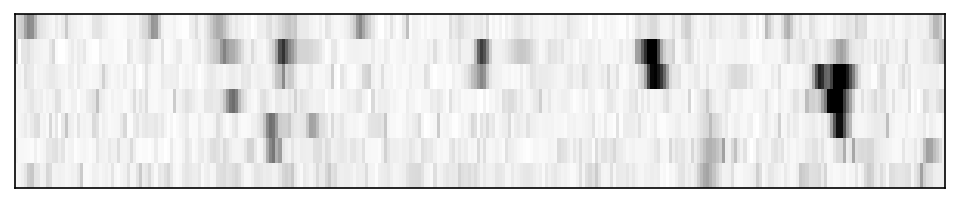

In [131]:

plot.show_tif(vmap_3d[:, 309, 312:612], cbar=False, cmap='Greys', px_py = (1,8), alpha=1.0)

In [49]:
coords = [stat["coords"] for stat in stats_3d]

In [50]:
import colorcet

In [161]:
filt = mrs > 0.9

In [162]:
cell_id_vol, rgb_vol = ui.make_label_vols(stats_3d, (7,1000,800), lam_max=0.05, cmap='cet_glasbey_dark',
                                         iscell = filt)

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7f3a04510fd0>)

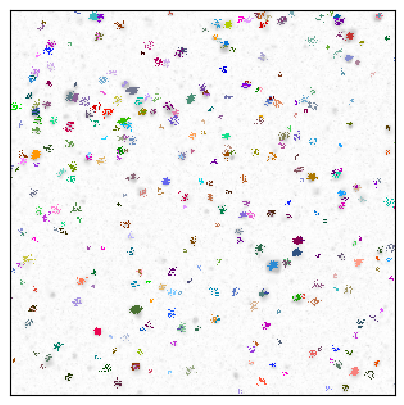

In [163]:
f,ax = plt.subplots(figsize=(5,5))
zidx = 3
plot.show_tif(vmap_3d[zidx,290:590, 312:612], cbar=False, cmap='Greys',ax=ax, alpha=0.25)
plot.show_tif(rgb_vol[zidx,290:590, 312:612],ax=ax)
# ax.axhline(20)
# ax.axhline(12)


In [244]:
spks.shape

(34994, 2000)

(None, <Axes: >, <matplotlib.image.AxesImage at 0x7f3a044b6100>)

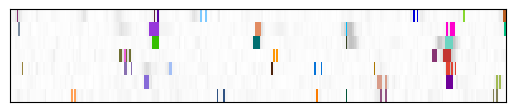

In [164]:
f,ax = plt.subplots()
plot.show_tif(vmap_3d[:, 309, 312:612], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.25)
plot.show_tif(rgb_vol[:,309, 312:612],ax=ax, px_py = (1,8))

In [194]:
putative_merge = ( 6447    , 10111 ,15034,20201 ,26561     )
putative_merge2 = (466, 5081     , 11890 )

In [ ]:
st

In [ ]:

n.save('/mnt/md0/runs/pub-figs/outputs/s2p/iscell.npy', iscell)
n.save('/mnt/md0/runs/pub-figs/outputs/s2p/filt.npy', filt)
n.save('/mnt/md0/runs/pub-figs/outputs/s2p/mrs.npy', mrs)

n.save('/mnt/md0/runs/pub-figs/outputs/s2p/spks.npy', spks)
n.save('/mnt/md0/runs/pub-figs/outputs/s2p/F.npy', Fs)
n.save('/mnt/md0/runs/pub-figs/outputs/s2p/stats.npy', stats_3d)
n.save('/mnt/md0/runs/pub-figs/outputs/s2p/vmap.npy', vmap_3d)



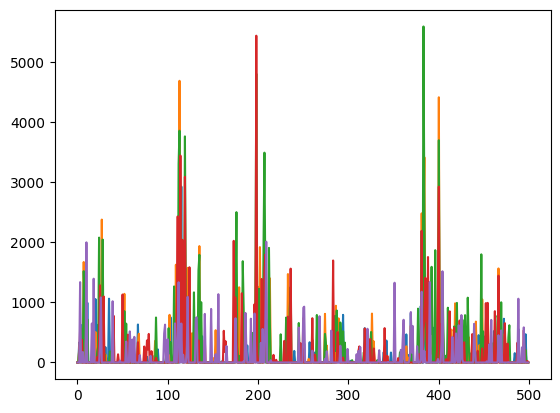

In [246]:

plt.plot(spks[n.array(putative_merge), :500].T);

In [181]:
import colorcet

In [152]:
fx = Fs[filt]
sx = spks[filt]

In [155]:
fcorr.shape

(5376, 5376)

In [199]:
fcorr_full = n.corrcoef(Fs)
scorr_full = n.corrcoef(spks)

In [173]:
print(fcorr_full[putative_merge2[0],putative_merge2[1]])

0.2132001936360506


In [200]:
corrs1 = []
scorrs1 = []
for i in range(len(putative_merge)):
    for j in range(i):
        corrs1.append(fcorr_full[putative_merge[i],putative_merge[j]])
        scorrs1.append(scorr_full[putative_merge[i],putative_merge[j]])

corrs2 = []
scorrs2 = []
for i in range(len(putative_merge2)):
    for j in range(i):
        corrs2.append(fcorr_full[putative_merge2[i],putative_merge2[j]])
        scorrs2.append(scorr_full[putative_merge2[i],putative_merge2[j]])

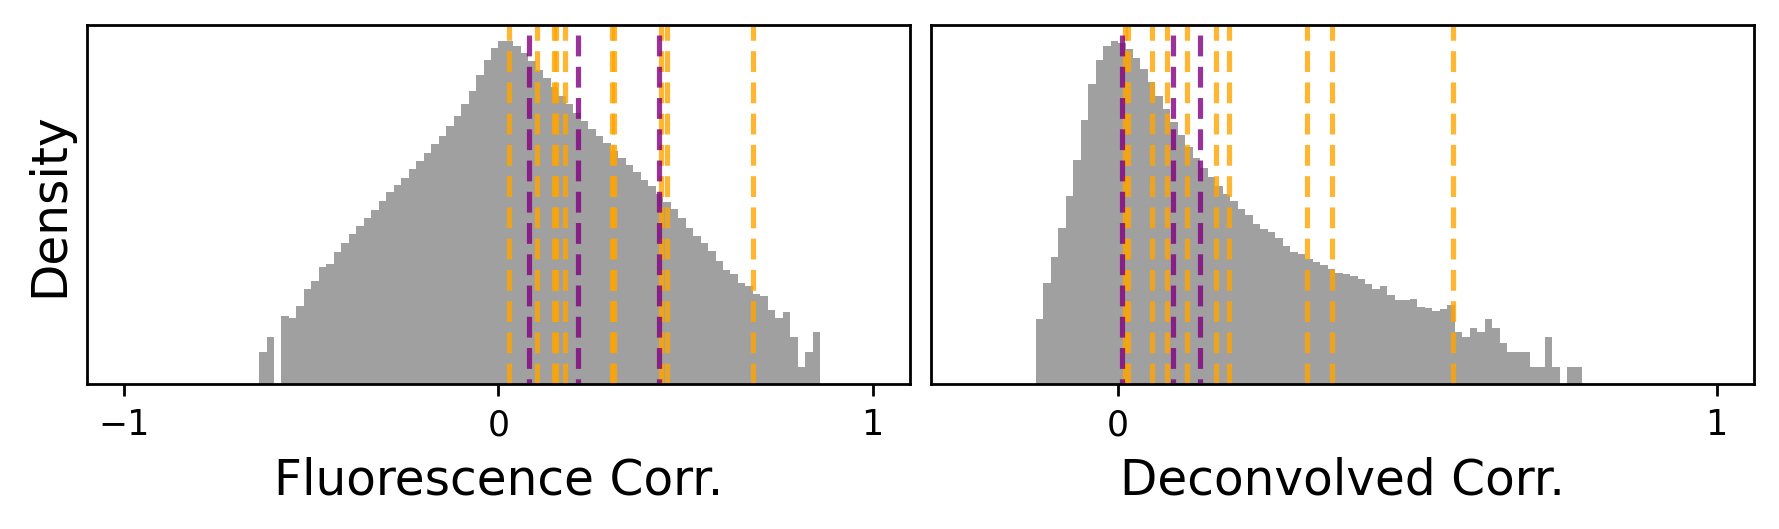

In [239]:
f,axs = plt.subplots(1,2,figsize=(7,2), dpi=250, layout='constrained')
la = 0.8
lw = 1.5
ax = axs[0]
ax.hist(fcorr_flat, bins=n.linspace(-1.0,1,101),log=True, color='grey', alpha=0.75, density=True)
for cx in corrs1:
    ax.axvline(cx, color='orange', lw=lw, linestyle=(0, (4,2)), alpha=la)
for cx in corrs2:
    ax.axvline(cx, color='purple', lw=lw, linestyle=(3, (4,2)), alpha=la)
ax.set_yticks([])
ax.set_ylabel("Density", fontsize=14)
ax.set_xlabel("Fluorescence Corr.", fontsize=14)
ax.set_xticks([-1,0,1.0])
    


ax = axs[1]
ax.hist(scorr_flat, bins=n.linspace(-0.25,1,101),log=True, color='grey', alpha=0.75, density=True)
ax.set_xlabel("Deconv. Corr.")
for cx in scorrs1:
    ax.axvline(cx, color='orange', lw=lw, linestyle=(0, (4,2)), alpha=la)
for cx in scorrs2:
    ax.axvline(cx, color='purple', lw=lw, linestyle=(3, (4,2)), alpha=la)
ax.set_yticks([])
# ax.set_ylabel("Density", fontsize=14)
ax.set_xlabel("Deconvolved Corr.", fontsize=14)
ax.set_xticks([0,1.0])